In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from matplotlib import image
from pathlib import Path
from tensorflow.keras import models, layers, Model, Input

from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, UpSampling2D, MaxPooling2D, concatenate

from PIL import Image
from numpy import asarray

In [2]:
isic_input_path = './../../../dataset/ISIC2018_Task1-2_Training_Input_x2/*.jpg'

isic_groundTruth_path = './../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2/*.png'

In [3]:
isic_input = sorted(glob.glob(isic_input_path))
isic_groundTruth = sorted(glob.glob(isic_groundTruth_path))

DATASET_SIZE = len(isic_input)
BATCH_SIZE = 8
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 4
# print(len(isic_groundTruth))

In [4]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

# print(train_size, val_size, test_size)

In [5]:
full_ds = tf.data.Dataset.from_tensor_slices((isic_input, isic_groundTruth))
full_ds = full_ds.shuffle(DATASET_SIZE, reshuffle_each_iteration=False)

train_ds = full_ds.take(train_size)

# skip the dataset for train
test_ds = full_ds.skip(train_size)

val_ds = full_ds.skip(val_size)
test_ds = full_ds.take(test_size)

In [6]:
for image, label in train_ds.take(5):
    print('Image file:', image.numpy())
    print('Label:', label.numpy())

Image file: b'./../../../dataset/ISIC2018_Task1-2_Training_Input_x2\\ISIC_0000143.jpg'
Label: b'./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0000143_segmentation.png'
Image file: b'./../../../dataset/ISIC2018_Task1-2_Training_Input_x2\\ISIC_0010593.jpg'
Label: b'./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0010593_segmentation.png'
Image file: b'./../../../dataset/ISIC2018_Task1-2_Training_Input_x2\\ISIC_0009188.jpg'
Label: b'./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0009188_segmentation.png'
Image file: b'./../../../dataset/ISIC2018_Task1-2_Training_Input_x2\\ISIC_0014475.jpg'
Label: b'./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0014475_segmentation.png'
Image file: b'./../../../dataset/ISIC2018_Task1-2_Training_Input_x2\\ISIC_0000544.jpg'
Label: b'./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0000544_segmentation.png'


In [7]:
def get_palette(a_input):
    sample = cv2.cvtColor(cv2.imread((a_input)), cv2.COLOR_RGB2RGBA)
    print(sample.shape)
    sample = cv2.resize(sample, (256,256))
    # print(test.shape)
    # print(test)

    my_list= []
    for i in range(256):
        for j in range(256):
            my_list.append(sample[i,j,:].tolist())
    
    palette = sort_and_deduplicate(my_list)
    # print(palette)
    return palette

def uniq(lst):
    last = object()
    for item in lst:
        if item == last:
            continue
        yield item
        last = item

def sort_and_deduplicate(l):
    return list(uniq(sorted(l, reverse=True)))


palette = get_palette(isic_groundTruth[0])
# palette2 = get_palette(isic_groundTruth[1])
palette = [[255, 255, 255, 255], [0, 0, 0, 255]]
palette = [255, 0]
print(palette)

(384, 511, 4)
[255, 0]


In [8]:
# sample2 = cv2.cvtColor(cv2.imread((isic_groundTruth[0])), cv2.COLOR_RGB2RGBA)
# sample2 = tf.io.read_file(isic_groundTruth[0])
# sample2 = tf.image.decode_png(sample2, channels=1).numpy()
# print(sample2.shape)
# # for i in sample2:
# #     for j in i:
# #         print(j)
# unique = np.unique(sample2)
# print(unique)

In [9]:
def decode_img(image):
    image = tf.image.decode_jpeg(image, channels=0)
    # resize the image 256*256 
    image =  tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    # Standardise values to be in the [0, 1] range.
    image = tf.cast(image, tf.float32) / 255.0
    
    return image
    
def decode_label(label):
#     label = tf.image.decode_png(label)
#     label = label == [255, 0]
#     label = tf.reshape(label, (256, 256, 2))
#     print(label.shape)
    
#     return label

    label = tf.image.decode_png(label, channels=1)
    # Resize the image to the desired size.
    label =  tf.image.resize(label, [IMG_WIDTH, IMG_HEIGHT])
    print(label.shape)
    
    one_hot_map = []

    for clr in palette:
        class_map = tf.equal(label, clr)
        class_map = tf.reduce_all(class_map,axis=-1)
        one_hot_map.append(class_map)
    
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.uint8)
    
    return one_hot_map

    
def process_data(image, label):
    image = tf.io.read_file(image)
    image = decode_img(image)
    
    label = tf.io.read_file(label)
    label = decode_label(label)
    
    return image, label   

In [10]:
# Use Dataset.map to apply this transformation.
processed_train_ds = train_ds.map(process_data)
processed_val_ds = val_ds.map(process_data)

processed_test_ds = test_ds.map(process_data)

(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


Image shape: b'./../../../dataset/ISIC2018_Task1-2_Training_Input_x2\\ISIC_0000143.jpg'
Label: b'./../../../dataset/ISIC2018_Task1_Training_GroundTruth_x2\\ISIC_0000143_segmentation.png'

Image shape: (256, 256, 3)
Label: (256, 256, 2)
tf.Tensor(
[[[0 1]
  [0 1]
  [0 1]
  ...
  [0 1]
  [0 1]
  [0 1]]

 [[0 1]
  [0 1]
  [0 1]
  ...
  [0 1]
  [0 1]
  [0 1]]

 [[0 1]
  [0 1]
  [0 1]
  ...
  [0 1]
  [0 1]
  [0 1]]

 ...

 [[0 1]
  [0 1]
  [0 1]
  ...
  [0 1]
  [0 1]
  [0 1]]

 [[0 1]
  [0 1]
  [0 1]
  ...
  [0 1]
  [0 1]
  [0 1]]

 [[0 1]
  [0 1]
  [0 1]
  ...
  [0 1]
  [0 1]
  [0 1]]], shape=(256, 256, 2), dtype=uint8)


(-0.5, 255.5, 255.5, -0.5)

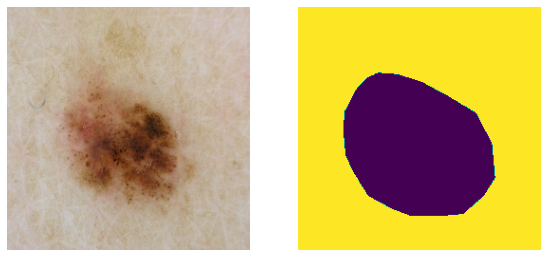

In [11]:
for image, label in train_ds.take(1):
    print('Image shape:', image.numpy())
    print('Label:', label.numpy())
print()
for image, label in processed_train_ds.take(1):
    print('Image shape:', image.numpy().shape)
    print('Label:', label.numpy().shape)
plt.figure(figsize=(20, 10))

print(label)
plt.subplot(1, 4, 1)
plt.imshow(image.numpy())
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(tf.argmax(label.numpy(), axis=2))
plt.axis('off')

In [12]:
from model import *

model = unet(len(palette))
if (len(palette) > 2):
    model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
else:
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
def dice_coef(img, img2):
    if img.shape != img2.shape:
        raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
    else:
        img = img.numpy().astype(np.bool)
        img2 = img2.astype(np.bool)
        intersection = np.logical_and(img, img2)
        value = (2. * intersection.sum())  / (img.sum() + img2.sum())
    return value 

# preds_test[0].astype(np.bool)
def display(ground_truth, prediction, num):
    plt.figure(figsize=(20, 20))
    for i in range(num):
        plt.subplot(4, 2, 2*i+1)
        plt.imshow(tf.argmax(ground_truth[i], axis=-1))
        plt.subplot(4, 2, 2*i+2)
        plt.imshow(tf.argmax(prediction[i], axis=-1))

        print("DICE SIMILARITY FOR INPUT {}: {}".format(i, dice_coef(ground_truth[i], prediction[i])))
    plt.show()
    
# display(label_test_batch, preds_test)

def show_predictions(processed_test_ds, num=3):
    image_test_batch, label_test_batch = next(iter(processed_test_ds.batch(3)))
    prediction = model.predict(image_test_batch)
    display(label_test_batch, prediction, num)

from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(processed_test_ds)

DICE SIMILARITY FOR INPUT 0: 0.6646018420409161
DICE SIMILARITY FOR INPUT 1: 0.6637509621315227
DICE SIMILARITY FOR INPUT 2: 0.6661782065372247


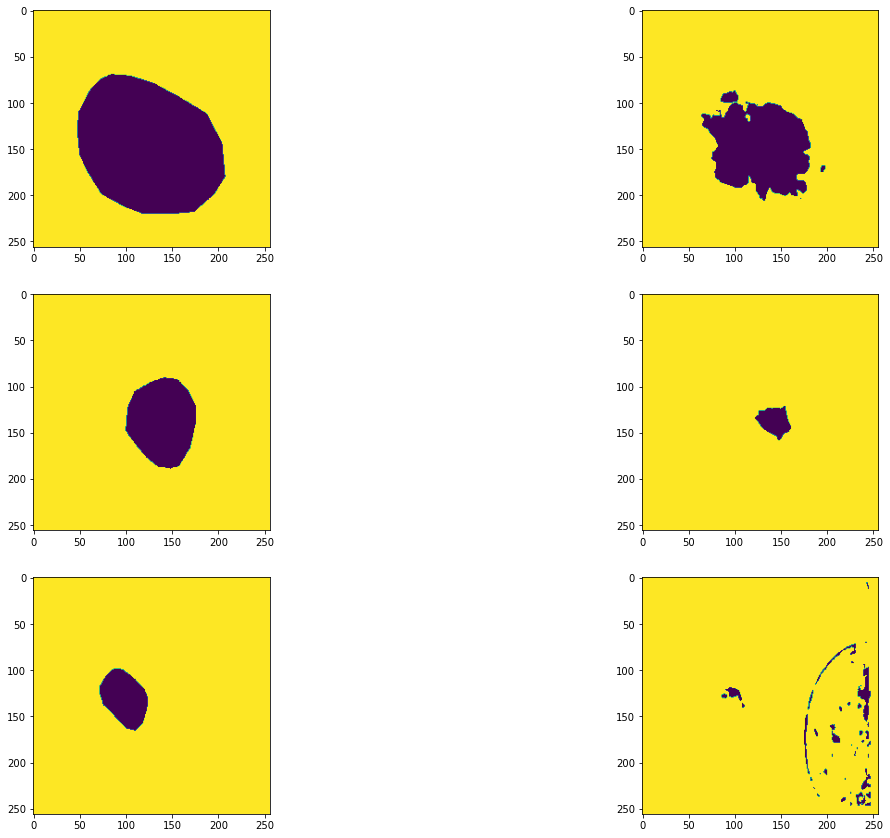

605/605 [==============================] - 189s 313ms/step - loss: 0.3404 - accuracy: 0.8683 - val_loss: 0.3386 - val_accuracy: 0.8668


In [14]:
history = model.fit(processed_train_ds.batch(3), 
                    validation_data=processed_val_ds.batch(BATCH_SIZE), 
                    epochs=10, callbacks=[DisplayCallback()])

In [15]:
test_loss, test_acc = model.evaluate(processed_test_ds.batch(BATCH_SIZE), verbose=2)

49/49 - 12s - loss: 0.3224 - accuracy: 0.8703


In [16]:
image_test_batch, label_test_batch = next(iter(processed_test_ds.batch(3)))
prediction = model.predict(image_test_batch)

In [17]:
prediction

array([[[[6.55405447e-02, 9.52081919e-01],
         [8.66061635e-03, 9.83698010e-01],
         [2.97402986e-03, 9.88596976e-01],
         ...,
         [5.15274517e-03, 9.79875207e-01],
         [3.03780101e-02, 9.40321922e-01],
         [2.17339993e-02, 9.70523000e-01]],

        [[2.65324935e-02, 9.80688453e-01],
         [5.56836929e-03, 9.88300979e-01],
         [2.81632110e-03, 9.89253104e-01],
         ...,
         [3.56811751e-03, 9.93548214e-01],
         [9.27172322e-03, 9.83758032e-01],
         [8.95027164e-03, 9.90707040e-01]],

        [[1.90819316e-02, 9.77227747e-01],
         [6.05423283e-03, 9.81586874e-01],
         [4.21325676e-03, 9.86410558e-01],
         ...,
         [3.55946692e-03, 9.94596064e-01],
         [8.04796349e-03, 9.85544503e-01],
         [8.19852669e-03, 9.91939485e-01]],

        ...,

        [[4.33833227e-02, 9.28499520e-01],
         [6.27464009e-03, 9.92537439e-01],
         [5.12145180e-03, 9.94382620e-01],
         ...,
         [1.43039078e